<AxesSubplot:>

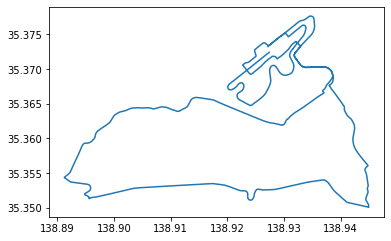

In [61]:
import geopandas as gpd
track = gpd.GeoDataFrame(columns=['name', 'geometry'], 
     geometry='geometry')
gdf = gpd.read_file('data/tokyo.gpx', layer='tracks')
gdf.plot()

In [120]:
from shapely import geometry, ops
singleline = ops.linemerge(gdf.geometry[0])
gdf.geometry[0]=singleline

ValueError: Cannot linemerge LINESTRING (138.9275082 35.3724509, 138.9272 35.37225, 138.92669 35.37192, 138.92617 35.37158, 138.92583 35.37135, 138.92445 35.37045, 138.92307 35.36955, 138.92225 35.36901, 138.92221 35.36899, 138.92064 35.36798, 138.92048 35.36788, 138.92037 35.3678, 138.92024 35.36769, 138.9202 35.36763, 138.92016 35.36759, 138.92012 35.36751, 138.9201 35.36745, 138.92009 35.36741, 138.92009 35.36736, 138.92009 35.36733, 138.9201 35.36729, 138.92011 35.36725, 138.92012 35.36723, 138.92014 35.3672, 138.92017 35.36716, 138.9202 35.36711, 138.92025 35.36707, 138.92033 35.36703, 138.92038 35.36701, 138.92046 35.36699, 138.92054 35.36698, 138.92063 35.36698, 138.92072 35.36699, 138.92082 35.36701, 138.92087 35.36703, 138.92101 35.36708, 138.92119 35.36716, 138.92126 35.3672, 138.92129 35.36722, 138.92139 35.36728, 138.92153 35.36739, 138.92159 35.36744, 138.92164 35.36747, 138.92202 35.36783, 138.92203 35.36784, 138.92208 35.36788, 138.92215 35.36792, 138.92223 35.36795, 138.9223 35.36798, 138.92235 35.36799, 138.92242 35.368, 138.92248 35.368, 138.92257 35.36798, 138.92265 35.36795, 138.9227 35.36792, 138.92274 35.36789, 138.92278 35.36785, 138.92282 35.3678, 138.92287 35.36773, 138.92287 35.36772, 138.9228749 35.3677219, 138.92291 35.36762, 138.92293 35.3675, 138.92292 35.36741, 138.9229 35.36732, 138.92288 35.36726, 138.92286 35.36722, 138.92281 35.36711, 138.92267 35.36693, 138.92251 35.36681, 138.92239 35.36674, 138.92219 35.36665, 138.92205 35.36658, 138.92196 35.36653, 138.92187 35.36645, 138.9218 35.36638, 138.92177 35.36631, 138.92174 35.36623, 138.92172 35.36613, 138.92174 35.36602, 138.92177 35.36591, 138.92184 35.3658, 138.92192 35.36571, 138.92198 35.36566, 138.92204 35.36561, 138.92214 35.36555, 138.92225 35.36549, 138.92237 35.36544, 138.9225 35.36539, 138.92262 35.36535, 138.92315 35.3651, 138.92339 35.365, 138.92341 35.36498, 138.92358 35.36491, 138.92369 35.36487, 138.9238 35.36482, 138.92393 35.36477, 138.92397 35.36475, 138.92402 35.36474, 138.92407 35.36473, 138.92412 35.36472, 138.92417 35.36473, 138.92423 35.36474, 138.9243 35.36477, 138.92475 35.36504, 138.92493 35.36515, 138.92564 35.36558, 138.9257 35.36562, 138.92614 35.36592, 138.92615 35.36593, 138.92643 35.36614, 138.92663 35.36633, 138.92674 35.36644, 138.92686 35.36661, 138.92693 35.36672, 138.92717 35.36709, 138.92738 35.36743, 138.92745 35.36757, 138.92752 35.3677, 138.92761 35.36793, 138.92765 35.3681, 138.92767 35.36826, 138.92767 35.36846, 138.92765 35.36859, 138.9275 35.36949, 138.92748 35.36964, 138.92748 35.36979, 138.92751 35.36993, 138.92754 35.37005, 138.9276 35.37018, 138.92768 35.37027, 138.92775 35.37035, 138.92786 35.37042, 138.92795 35.37046, 138.92805 35.37048, 138.92811 35.37049, 138.92816 35.37049, 138.92821 35.37049, 138.92826 35.37048, 138.92831 35.37047, 138.92839 35.37044, 138.92845 35.3704, 138.92852 35.37036, 138.92858 35.37032, 138.92863 35.37027, 138.92863 35.37026, 138.92867 35.37022, 138.92888 35.36996, 138.92911 35.36966, 138.92917 35.36959, 138.9293 35.36944, 138.92945 35.36932, 138.92965 35.36921, 138.92974 35.36917, 138.92985 35.36913, 138.92996 35.3691, 138.93007 35.36909, 138.93016 35.36908, 138.93025 35.36908, 138.9304 35.36908, 138.93053 35.3691, 138.93069 35.36914, 138.93084 35.36918, 138.9311 35.36927, 138.9312 35.36933, 138.93133 35.3694, 138.93151 35.36958, 138.9316 35.36975, 138.93164 35.36983, 138.93171 35.37002, 138.93173 35.37015, 138.93175 35.37024, 138.93175 35.37042, 138.93174 35.37045, 138.93171 35.37062, 138.93166 35.37077, 138.9316 35.37088, 138.93144 35.37115, 138.93125 35.37144, 138.9311 35.37166, 138.93105 35.37176, 138.93104 35.37183, 138.93102 35.37193, 138.93103 35.37205, 138.93105 35.37215, 138.93108 35.37223, 138.93111 35.3723, 138.93116 35.37239, 138.93123 35.37249, 138.93139 35.37268, 138.93161 35.37291, 138.931607 35.3729069, 138.93205 35.37337, 138.93314 35.37447, 138.93341 35.37475, 138.93359 35.37499, 138.9337 35.37521, 138.9338 35.37548, 138.93389 35.37592, 138.93388 35.37598, 138.93387 35.37603, 138.93385 35.37608, 138.93383 35.37611, 138.93379 35.37616, 138.93376 35.37619, 138.93372 35.37622, 138.93367 35.37625, 138.93362 35.37627, 138.93356 35.37628, 138.93351 35.37629, 138.93345 35.37629, 138.9334 35.37629, 138.93335 35.37628, 138.9333 35.37627, 138.93326 35.37625, 138.93313 35.37618, 138.93246 35.37573, 138.93092 35.37471, 138.93079 35.37462, 138.9307884 35.3746221, 138.9302241 35.3751951, 138.92991 35.37499, 138.92973 35.37488, 138.92961 35.3748, 138.9295 35.37475, 138.92941 35.3747, 138.92939 35.37468, 138.92928 35.37462, 138.92917 35.37455, 138.92868 35.37423, 138.92837 35.37402, 138.92806 35.37382, 138.92788 35.37369, 138.92745 35.37341, 138.9274457 35.3734081, 138.92736 35.37338, 138.92729 35.37337, 138.92722 35.37338, 138.92716 35.3734, 138.92713 35.37341, 138.92709 35.37343, 138.92701 35.37348, 138.92699 35.37349, 138.92694 35.37353, 138.92673 35.37367, 138.92667 35.37371, 138.92663 35.37373, 138.92656 35.37375, 138.92652 35.37375, 138.92651 35.37375, 138.92648 35.37375, 138.92644 35.37375, 138.92641 35.37375, 138.92639 35.37374, 138.92636 35.37373, 138.92635 35.37373, 138.92634 35.37373, 138.92628 35.37369, 138.92587 35.37343, 138.92548 35.37317, 138.92544 35.37314, 138.92524 35.37301, 138.92495 35.37282, 138.92491 35.37279, 138.92488 35.37276, 138.92486 35.37274, 138.92484 35.3727, 138.92483 35.37267, 138.92483 35.37265, 138.92482 35.37261, 138.92483 35.37258, 138.92483 35.37254, 138.92484 35.37251, 138.92494 35.37227, 138.92498 35.37217, 138.92499 35.37213, 138.92506 35.37196, 138.92507 35.37191, 138.92508 35.37188, 138.92508 35.37186, 138.92507 35.37184, 138.92506 35.37183, 138.92504 35.3718, 138.92502 35.37178, 138.92496 35.37174, 138.92439 35.37136, 138.92417 35.37122, 138.92401 35.37111, 138.92384 35.371, 138.9238 35.37098, 138.92375 35.37096, 138.9237 35.37094, 138.92366 35.37092, 138.92362 35.37092, 138.92351 35.3709, 138.92339 35.37089, 138.92329 35.37087, 138.92322 35.37086, 138.92318 35.37084, 138.92313 35.37082, 138.92308 35.3708, 138.92306 35.37078, 138.92302 35.37075, 138.92272 35.37056, 138.9227155 35.3705566, 138.92299 35.37028, 138.9233 35.36996, 138.92347 35.36978, 138.92365 35.3696, 138.92368 35.36957, 138.92391 35.36934, 138.924 35.36927, 138.92406 35.36924, 138.92411 35.36923, 138.92415 35.36923, 138.9242 35.36923, 138.92424 35.36924, 138.92427 35.36925, 138.92434 35.36929, 138.92443 35.36934, 138.92486 35.36962, 138.92497 35.36969, 138.92507 35.36976, 138.92594 35.37035, 138.92601 35.3704, 138.92664 35.37095, 138.92666 35.37096, 138.92694 35.37116, 138.92699 35.3712, 138.92713 35.37129, 138.92733 35.37142, 138.92739 35.37146, 138.92765 35.37161, 138.92789 35.37175, 138.92795 35.37178, 138.928 35.3718, 138.92809 35.37181, 138.9282 35.3718, 138.92821 35.3718, 138.9282129 35.3718006, 138.9284 35.37178, 138.92847 35.37175, 138.92855 35.37172, 138.92861 35.37166, 138.92866 35.3716, 138.92881 35.37144, 138.9288109 35.3714392, 138.9291 35.37163, 138.9294 35.37178, 138.92951 35.37185, 138.92969 35.37197, 138.92986 35.37208, 138.93002 35.3722, 138.93012 35.37227, 138.93019 35.37233, 138.93041 35.37251, 138.9305 35.37258, 138.93057 35.37264, 138.93073 35.37275, 138.93092 35.37293, 138.931 35.37301, 138.93106 35.37309, 138.93117 35.37322, 138.93123 35.37329, 138.93128 35.37335, 138.93133 35.37341, 138.93141 35.37348, 138.93155 35.37359, 138.93183 35.37377, 138.93194 35.37384, 138.93202 35.37389, 138.9321 35.37395, 138.932101 35.3739531, 138.93216 35.37391, 138.93222 35.37386, 138.93248 35.37365, 138.93273 35.37345, 138.93295 35.37327, 138.9329515 35.3732685, 138.93287 35.37319, 138.9327 35.37302, 138.93248 35.37279, 138.93225 35.37256, 138.93208 35.3724, 138.93201 35.37233, 138.93194 35.37225, 138.9319 35.37219, 138.93187 35.37213, 138.93186 35.37208, 138.93184 35.37201, 138.93184 35.37195, 138.93184 35.37187, 138.93187 35.3718, 138.93192 35.3717, 138.93194 35.37167, 138.93201 35.37159, 138.93205 35.37154, 138.93211 35.37147, 138.93239 35.37116, 138.93245 35.37109, 138.93255 35.37099, 138.93257 35.37096, 138.93276 35.37074, 138.93282 35.37067, 138.93288 35.37062, 138.93298 35.37052, 138.93299 35.37051, 138.93306 35.37046, 138.93313 35.37041, 138.9332 35.37037, 138.93326 35.37035, 138.93333 35.37031, 138.93334 35.37031, 138.93345 35.37027, 138.93352 35.37025, 138.93356 35.37024, 138.93376 35.37021, 138.93378 35.37021, 138.93393 35.37021, 138.9344 35.37022, 138.93441 35.37022, 138.93462 35.37022, 138.93484 35.37023, 138.93494 35.37023, 138.93509 35.37023, 138.93518 35.37024, 138.93576 35.37025, 138.93624 35.37027, 138.93661 35.37027, 138.9369 35.37028, 138.93708 35.37028, 138.93713 35.37028, 138.93728 35.37026, 138.93741 35.37024, 138.93754 35.3702, 138.93763 35.37017, 138.93768 35.37016, 138.93771 35.37015, 138.93775 35.37013, 138.9378 35.37011, 138.93787 35.37007, 138.93795 35.37003, 138.93796 35.37003, 138.93804 35.36998, 138.93808 35.36995, 138.93811 35.36993, 138.93816 35.36989, 138.93824 35.36982, 138.93832 35.36974, 138.93841 35.36964, 138.93847 35.36954, 138.93851 35.36947, 138.93867 35.36896, 138.938669 35.368958, 138.9385 35.36868, 138.9384 35.36854, 138.93828 35.36838, 138.93806 35.36814, 138.93804 35.36813, 138.93781 35.36789, 138.93772 35.36782, 138.93754 35.36765, 138.93743 35.36748, 138.93735 35.3673, 138.93729 35.36724, 138.93722 35.36715, 138.93716 35.36708, 138.93699 35.36698, 138.93699 35.36697, 138.93697 35.36696, 138.93696 35.36695, 138.93691 35.3669, 138.93689 35.36688, 138.93685 35.36684, 138.93685 35.3668, 138.93685 35.36678, 138.93686 35.36676, 138.93687 35.36675, 138.93688 35.36673, 138.93692 35.3667, 138.93701 35.36663, 138.93709 35.36655, 138.9370921 35.3665464, 138.93668 35.3663, 138.93655 35.36627, 138.93633 35.36614, 138.93588 35.3659, 138.93553 35.3657, 138.93499 35.36538, 138.93481 35.36527, 138.93451 35.3651, 138.93431 35.36498, 138.93401 35.36481, 138.934 35.36481, 138.93395 35.36478, 138.93373 35.36464, 138.93339 35.36444, 138.93328 35.36438, 138.93324 35.36436, 138.93319 35.36433, 138.93302 35.36425, 138.93295 35.36421, 138.93293 35.3642, 138.93279 35.36412, 138.93274 35.3641, 138.9327 35.36407, 138.93246 35.36396, 138.93245 35.36395, 138.9323 35.36387, 138.93206 35.36375, 138.9319 35.36366, 138.9316 35.36348, 138.93144 35.36337, 138.9314362 35.3633675, 138.93125 35.36324, 138.93111 35.36313, 138.93067 35.36276, 138.93059 35.36276, 138.9304 35.36254, 138.93032 35.36242, 138.93029 35.36236, 138.93024 35.36228, 138.93015 35.36216, 138.93006 35.36206, 138.92999 35.36198, 138.92995 35.36195, 138.9299513 35.3619453, 138.92992 35.36195, 138.92991 35.36195, 138.9299 35.36195, 138.92989 35.36195, 138.92987 35.36195, 138.92986 35.36195, 138.92985 35.36195, 138.92984 35.36195, 138.92982 35.36194, 138.92981 35.36194, 138.9298 35.36194, 138.92979 35.36193, 138.92978 35.36193, 138.92977 35.36192, 138.92976 35.36192, 138.92975 35.36191, 138.92974 35.3619, 138.92973 35.36189, 138.92972 35.36188, 138.92952 35.36191, 138.92949 35.36191, 138.92928 35.36196, 138.92917 35.36197, 138.92911 35.362, 138.929 35.36202, 138.9289 35.36202, 138.92883 35.36204, 138.92866 35.36207, 138.92845 35.36211, 138.92834 35.36213, 138.92813 35.36216, 138.92766 35.36222, 138.92745 35.36225, 138.92728 35.36228, 138.92703 35.36235, 138.92695 35.36237, 138.92673 35.36242, 138.92657 35.36246, 138.92595 35.36266, 138.92588 35.36268, 138.92553 35.36279, 138.92498 35.36298, 138.92457 35.36311, 138.92355 35.36346, 138.92337 35.36352, 138.92314 35.36359, 138.9213 35.36421, 138.92032 35.36454, 138.92025 35.36456, 138.92004 35.36463, 138.9195 35.36482, 138.91941 35.36484, 138.91921 35.36492, 138.91873 35.36508, 138.91838 35.36521, 138.91833 35.36523, 138.91819 35.36528, 138.918 35.36535, 138.91776 35.36544, 138.91773 35.36544, 138.91755 35.36551, 138.91744 35.36554, 138.91735 35.36555, 138.91732 35.36555, 138.91723 35.36556, 138.91719 35.36557, 138.91713 35.36558, 138.91656 35.36565, 138.9165 35.36566, 138.91591 35.36573, 138.91585 35.36574, 138.91563 35.36577, 138.91551 35.36578, 138.91541 35.36579, 138.91481 35.36586, 138.91466 35.36587, 138.91455 35.36588, 138.91445 35.36588, 138.91434 35.36587, 138.91426 35.36585, 138.91416 35.36583, 138.91409 35.36581, 138.914 35.36578, 138.91393 35.36576, 138.91386 35.36572, 138.91376 35.36566, 138.91371 35.36562, 138.91364 35.36557, 138.91358 35.3655, 138.91354 35.36544, 138.91352 35.36542, 138.91349 35.36537, 138.91341 35.36524, 138.91338 35.36519, 138.91333 35.36511, 138.91311 35.36479, 138.91304 35.36471, 138.91299 35.36464, 138.91297 35.36462, 138.91293 35.36458, 138.91287 35.36452, 138.91284 35.3645, 138.9128 35.36447, 138.91277 35.36446, 138.91269 35.36443, 138.91258 35.36436, 138.91245 35.36431, 138.91234 35.36427, 138.91226 35.36424, 138.91209 35.36418, 138.91202 35.36414, 138.9119 35.36408, 138.91183 35.36405, 138.91181 35.36404, 138.91172 35.36399, 138.91167 35.36397, 138.91157 35.36393, 138.91151 35.3639, 138.91143 35.36388, 138.91134 35.36388, 138.91131 35.36388, 138.91119 35.36388, 138.91116 35.36389, 138.91108 35.36391, 138.91093 35.36395, 138.91088 35.36396, 138.91067 35.36403, 138.91064 35.36403, 138.91037 35.3641, 138.91016 35.36416, 138.90996 35.36422, 138.90943 35.3644, 138.90936 35.36442, 138.90935 35.36442, 138.90922 35.36445, 138.90912 35.36447, 138.90911 35.36447, 138.90889 35.36448, 138.90871 35.3645, 138.90867 35.3645, 138.90854 35.36451, 138.90844 35.36451, 138.9084 35.36451, 138.90835 35.36451, 138.9083 35.36451, 138.90825 35.3645, 138.9081 35.36447, 138.90761 35.36436, 138.90755 35.36434, 138.90724 35.36427, 138.90713 35.36425, 138.90704 35.36424, 138.90696 35.36424, 138.90689 35.36424, 138.90684 35.36424, 138.90676 35.36426, 138.90665 35.36429, 138.90649 35.36432, 138.90641 35.36435, 138.9063 35.36437, 138.90621 35.36438, 138.90613 35.36439, 138.90588 35.3644, 138.90576 35.36439, 138.90565 35.36438, 138.90528 35.36437, 138.90525 35.36437, 138.90483 35.36436, 138.90475 35.36436, 138.90444 35.3644, 138.90427 35.3644, 138.90413 35.3644, 138.90368 35.36437, 138.90349 35.36436, 138.9033 35.36435, 138.90314 35.36433, 138.90304 35.36432, 138.90291 35.36429, 138.9028 35.36425, 138.90265 35.3642, 138.90231 35.36408, 138.90219 35.36404, 138.90217 35.36403, 138.90205 35.36399, 138.90188 35.36395, 138.90159 35.3639, 138.90153 35.36388, 138.90133 35.36384, 138.90124 35.36383, 138.90108 35.36379, 138.90093 35.36375, 138.90084 35.36371, 138.90068 35.36364, 138.90063 35.36362, 138.90049 35.36355, 138.90044 35.36353, 138.90041 35.36352, 138.90032 35.36347, 138.9002 35.3634, 138.9001 35.36333, 138.90005 35.36329, 138.90002 35.36326, 138.89996 35.3632, 138.8999 35.36313, 138.89974 35.36292, 138.89965 35.36281, 138.89953 35.36264, 138.89949 35.36259, 138.89936 35.36244, 138.89925 35.36231, 138.89917 35.36224, 138.89913 35.36222, 138.89909 35.36218, 138.899 35.36212, 138.89897 35.3621, 138.89892 35.36207, 138.89884 35.36202, 138.8988 35.36199, 138.89874 35.36196, 138.89863 35.3619, 138.89828 35.3617, 138.89826 35.3617, 138.89803 35.36157, 138.89765 35.36136, 138.89755 35.3613, 138.89747 35.36125, 138.8973 35.36115, 138.89716 35.36107, 138.89712 35.36104, 138.89692 35.36087, 138.89686 35.36081, 138.89679 35.3607, 138.89679 35.36069, 138.89675 35.36059, 138.89672 35.36052, 138.89672 35.36051, 138.89669 35.36038, 138.89668 35.36034, 138.89667 35.36032, 138.89663 35.36017, 138.89661 35.36012, 138.89655 35.36002, 138.8965 35.35996, 138.89649 35.35995, 138.89647 35.35992, 138.89643 35.35988, 138.89634 35.35982, 138.89619 35.35969, 138.89615 35.35966, 138.89603 35.35956, 138.89597 35.35952, 138.89595 35.35951, 138.89591 35.35948, 138.89581 35.35943, 138.89574 35.3594, 138.89557 35.35935, 138.89539 35.35931, 138.89525 35.3593, 138.89515 35.35929, 138.89504 35.3593, 138.89495 35.3593, 138.89491 35.3593, 138.89483 35.35929, 138.89476 35.35927, 138.89469 35.35924, 138.89464 35.35921, 138.8946 35.35917, 138.89448 35.35906, 138.89442 35.35899, 138.89436 35.35891, 138.89423 35.35867, 138.89389 35.35801, 138.89388 35.358, 138.8935 35.35731, 138.89347 35.35726, 138.8934 35.35715, 138.89312 35.35666, 138.89305 35.35655, 138.89303 35.3565, 138.89268 35.35589, 138.89257 35.35568, 138.8923 35.35521, 138.89229 35.35519, 138.89223 35.35512, 138.89217 35.35504, 138.8921 35.35497, 138.89192 35.35483, 138.89186 35.35479, 138.89169 35.35468, 138.89152 35.35457, 138.89121 35.35436, 138.89124 35.35432, 138.8912444 35.35432, 138.89131 35.35428, 138.8913117 35.3542814, 138.89222 35.35376, 138.8923 35.35373, 138.8923 35.35372, 138.89236 35.35371, 138.89251 35.35368, 138.89337 35.35358, 138.89359 35.35356, 138.89381 35.35354, 138.89425 35.35349, 138.89447 35.35346, 138.89469 35.35344, 138.8949 35.35342, 138.89512 35.35339, 138.89529 35.35337, 138.89534 35.35336, 138.89545 35.35334, 138.89555 35.3533, 138.89556 35.3533, 138.89561 35.35328, 138.89566 35.35325, 138.89572 35.35319, 138.89577 35.35313, 138.89584 35.353, 138.89586 35.35292, 138.89587 35.35284, 138.89587 35.35283, 138.89586 35.35276, 138.89584 35.35269, 138.89581 35.35261, 138.89576 35.35253, 138.89573 35.35249, 138.89572 35.35248, 138.89566 35.35243, 138.89552 35.35235, 138.89517 35.35218, 138.89495 35.35208, 138.89486 35.35203, 138.89483 35.352, 138.89482 35.35198, 138.89482 35.35197, 138.89482 35.35194, 138.89483 35.35192, 138.89485 35.35189, 138.89487 35.35186, 138.89489 35.35185, 138.8949 35.35184, 138.89508 35.35177, 138.89528 35.3517, 138.89536 35.35166, 138.89545 35.35162, 138.89547 35.3516, 138.89551 35.35157, 138.89555 35.35152, 138.89558 35.35146, 138.89559 35.35144, 138.89559 35.35143, 138.8956 35.35139, 138.8956 35.35133, 138.8956 35.3513, 138.8956013 35.3513031, 138.89566 35.35133, 138.89576 35.35136, 138.89588 35.35141, 138.89593 35.35143, 138.89599 35.35145, 138.89607 35.35146, 138.89617 35.35148, 138.89634 35.3515, 138.89652 35.35152, 138.8966 35.35152, 138.89674 35.35153, 138.89696 35.35156, 138.89719 35.3516, 138.89755 35.35167, 138.89787 35.35173, 138.89798 35.35175, 138.89805 35.35176, 138.89887 35.35191, 138.89909 35.35195, 138.89924 35.35198, 138.90019 35.35216, 138.90059 35.35224, 138.90145 35.3524, 138.90158 35.35243, 138.90167 35.35244, 138.90247 35.3526, 138.90339 35.35277, 138.9036 35.3528, 138.90365 35.35281, 138.90381 35.35282, 138.90382 35.35282, 138.90386 35.35283, 138.9039 35.35283, 138.90409 35.35284, 138.90423 35.35285, 138.90429 35.35286, 138.90536 35.35291, 138.90621 35.35295, 138.90646 35.35296, 138.90778 35.35303, 138.90825 35.35305, 138.90983 35.35313, 138.90989 35.35313, 138.91118 35.35319, 138.91316 35.35328, 138.9149 35.35336, 138.91496 35.35336, 138.91548 35.35339, 138.91554 35.35339, 138.91658 35.35344, 138.91661 35.35344, 138.91705 35.35346, 138.91714 35.35346, 138.91733 35.35347, 138.91748 35.35347, 138.91771 35.35344, 138.91782 35.35343, 138.91805 35.35341, 138.91824 35.35338, 138.91831 35.35338, 138.91841 35.35338, 138.91903 35.3533, 138.91913 35.35329, 138.91921 35.35328, 138.91928 35.35327, 138.91962 35.35323, 138.91966 35.35322, 138.91975 35.35318, 138.91988 35.35315, 138.92006 35.35311, 138.92012 35.3531, 138.92026 35.35306, 138.92034 35.35304, 138.92068 35.35294, 138.92137 35.35272, 138.9215 35.35268, 138.92158 35.35266, 138.92165 35.35264, 138.92171 35.35262, 138.92179 35.3526, 138.92192 35.35256, 138.92199 35.35253, 138.92212 35.3525, 138.92229 35.35246, 138.92246 35.35244, 138.92255 35.35244, 138.92266 35.35243, 138.92285 35.35243, 138.92316 35.35243, 138.92318 35.35242, 138.92323 35.3524, 138.92328 35.35238, 138.92332 35.35237, 138.92338 35.35234, 138.92344 35.35229, 138.92347 35.35227, 138.9235 35.35223, 138.92353 35.3522, 138.92355 35.35216, 138.92357 35.35213, 138.92358 35.35211, 138.9236 35.35205, 138.92361 35.35197, 138.92362 35.35192, 138.92361 35.3518, 138.92361 35.35176, 138.92361 35.35157, 138.92362 35.35151, 138.92362 35.35145, 138.92364 35.35139, 138.92366 35.35136, 138.92366 35.35134, 138.92366 35.35133, 138.92367 35.35132, 138.92367 35.3513, 138.92369 35.35128, 138.9237 35.35127, 138.92372 35.35125, 138.92374 35.35122, 138.92376 35.35121, 138.9238 35.35118, 138.92383 35.35116, 138.92386 35.35114, 138.92387 35.35114, 138.92388 35.35113, 138.92394 35.35112, 138.92398 35.35111, 138.92402 35.3511, 138.92406 35.35109, 138.92407 35.35109, 138.92408 35.35109, 138.92418 35.35109, 138.92426 35.35111, 138.92435 35.35114, 138.92444 35.3512, 138.9245 35.35125, 138.92452 35.35128, 138.92455 35.35133, 138.92456 35.35134, 138.92459 35.35138, 138.92462 35.35142, 138.92466 35.3515, 138.92468 35.35154, 138.9247 35.35158, 138.92471 35.35162, 138.92474 35.35177, 138.92478 35.35193, 138.92479 35.35198, 138.92484 35.35211, 138.92485 35.35214, 138.92486 35.35216, 138.92489 35.35223, 138.92493 35.3523, 138.92494 35.35232, 138.92498 35.35237, 138.92503 35.35244, 138.92505 35.35246, 138.92508 35.3525, 138.92514 35.35257, 138.92518 35.3526, 138.92525 35.35264, 138.92536 35.35266, 138.92547 35.35267, 138.92555 35.35266, 138.92564 35.35264, 138.92576 35.35262, 138.92587 35.35262, 138.92591 35.35261, 138.92599 35.35259, 138.92608 35.35258, 138.9262 35.35257, 138.92621 35.35257, 138.92629 35.35256, 138.92637 35.35256, 138.92641 35.35255, 138.92644 35.35255, 138.92751 35.35259, 138.92756 35.35259, 138.928 35.35261, 138.92849 35.35264, 138.92854 35.35264, 138.9286 35.35265, 138.9287 35.35268, 138.92888 35.35271, 138.92903 35.35273, 138.92916 35.35275, 138.92997 35.3529, 138.93009 35.35292, 138.93032 35.35297, 138.93044 35.35299, 138.93093 35.35308, 138.93104 35.3531, 138.93155 35.3532, 138.93166 35.35321, 138.93225 35.35332, 138.93372 35.35359, 138.93375 35.3536, 138.93421 35.35367, 138.93436 35.35369, 138.93457 35.35372, 138.93478 35.35375, 138.93492 35.35377, 138.93514 35.35379, 138.9354 35.35382, 138.93557 35.35384, 138.93601 35.3539, 138.93604 35.3539, 138.93619 35.35392, 138.93623 35.35392, 138.93645 35.35395, 138.93649 35.35396, 138.93667 35.35397, 138.93687 35.354, 138.93689 35.354, 138.93703 35.35399, 138.93711 35.35399, 138.93712 35.35399, 138.9372 35.35397, 138.93731 35.35393, 138.93741 35.35388, 138.93754 35.35381, 138.93774 35.35366, 138.93786 35.35356, 138.9379 35.35352, 138.93792 35.35351, 138.93805 35.35336, 138.93814 35.35325, 138.93827 35.35311, 138.93827 35.3531, 138.93839 35.35296, 138.93849 35.35285, 138.93865 35.35266, 138.93873 35.35258, 138.93875 35.35256, 138.93881 35.3525, 138.93895 35.35237, 138.93912 35.35224, 138.93922 35.35216, 138.9397 35.35182, 138.94006 35.35155, 138.94043 35.35128, 138.94067 35.35111, 138.94081 35.35101, 138.94083 35.351, 138.94087 35.35096, 138.941 35.35087, 138.94105 35.35084, 138.94108 35.35082, 138.94114 35.35079, 138.94121 35.35077, 138.94131 35.35074, 138.94147 35.35071, 138.94181 35.35065, 138.94197 35.35062, 138.94426 35.35021, 138.94446 35.35017, 138.94452 35.35016, 138.94495 35.35009, 138.9449468 35.3500948, 138.9449417 35.3500639, 138.94495 35.35013, 138.94497 35.35023, 138.94497 35.35031, 138.94496 35.35036, 138.94495 35.3504, 138.94492 35.35046, 138.94488 35.35054, 138.94479 35.35066, 138.94475 35.35073, 138.94465 35.35087, 138.94452 35.35104, 138.94449 35.35109, 138.94447 35.35117, 138.94447 35.35121, 138.94447 35.35126, 138.94449 35.35132, 138.94451 35.3514, 138.94452 35.35143, 138.94458 35.35161, 138.94473 35.3519, 138.94481 35.35209, 138.94483 35.35215, 138.94484 35.35218, 138.94486 35.35227, 138.94485 35.35234, 138.94484 35.35238, 138.94482 35.35245, 138.94479 35.35256, 138.94475 35.35264, 138.94472 35.3527, 138.94473 35.35273, 138.94476 35.35282, 138.9448 35.35293, 138.94483 35.35298, 138.94485 35.35305, 138.94488 35.35312, 138.94489 35.35317, 138.94488 35.35322, 138.94485 35.35341, 138.9448 35.35366, 138.94478 35.35379, 138.94477 35.35384, 138.94466 35.35438, 138.94466 35.35444, 138.94464 35.35456, 138.9446 35.35471, 138.94457 35.35481, 138.94456 35.35485, 138.94455 35.35489, 138.94451 35.35499, 138.94445 35.3551, 138.94437 35.35528, 138.94434 35.35533, 138.94432 35.35539, 138.94431 35.3555, 138.94434 35.35556, 138.94436 35.35561, 138.9444 35.35567, 138.94445 35.35573, 138.94448 35.35576, 138.94456 35.35583, 138.94459 35.35585, 138.94474 35.35598, 138.94486 35.35607, 138.9448591 35.3560722, 138.94476 35.35617, 138.94464 35.35629, 138.94461 35.35631, 138.94453 35.3564, 138.94424 35.35668, 138.94423 35.35669, 138.94409 35.35683, 138.94401 35.3569, 138.94396 35.35695, 138.94381 35.35711, 138.94368 35.35723, 138.94364 35.35727, 138.94353 35.35739, 138.94341 35.35752, 138.94333 35.3576, 138.94327 35.35768, 138.94311 35.35784, 138.94296 35.35802, 138.94276 35.35826, 138.94269 35.35836, 138.94264 35.35843, 138.94256 35.35856, 138.94255 35.35859, 138.9425 35.35867, 138.94245 35.35875, 138.9424 35.35889, 138.94238 35.35892, 138.94234 35.35903, 138.94232 35.35909, 138.94231 35.35913, 138.94228 35.35924, 138.94225 35.35936, 138.94223 35.35945, 138.94223 35.35948, 138.94221 35.35956, 138.9422 35.35963, 138.9422 35.35968, 138.94219 35.35986, 138.9422 35.35999, 138.94221 35.36003, 138.94223 35.36017, 138.94224 35.3602, 138.94227 35.36035, 138.94229 35.36045, 138.94231 35.36053, 138.94235 35.36071, 138.94235 35.36073, 138.94239 35.36088, 138.94242 35.36106, 138.94245 35.36116, 138.94248 35.36134, 138.94248 35.36156, 138.94246 35.36173, 138.94243 35.3619, 138.94239 35.362, 138.94233 35.3621, 138.94215 35.36239, 138.94203 35.36257, 138.94198 35.36264, 138.94188 35.36277, 138.94184 35.3628, 138.9418 35.36283, 138.94174 35.36286, 138.94165 35.36292, 138.94153 35.363, 138.94134 35.36315, 138.94117 35.36332, 138.94087 35.36374, 138.94085 35.36377, 138.94077 35.36391, 138.94075 35.36396, 138.94069 35.36407, 138.94069 35.36408, 138.94067 35.36418, 138.94068 35.36434, 138.94069 35.36444, 138.94068 35.36449, 138.94067 35.36452, 138.94063 35.36458, 138.94062 35.3646, 138.94058 35.36466, 138.94052 35.36472, 138.94048 35.36477, 138.94045 35.36481, 138.94033 35.36495, 138.94021 35.3651, 138.94014 35.36518, 138.94002 35.36532, 138.93964 35.36576, 138.93937 35.36605, 138.93933 35.3661, 138.93906 35.3664, 138.93855 35.36696, 138.93848 35.36701, 138.93836 35.36714, 138.93827 35.36725, 138.93825 35.36734, 138.93799 35.36759, 138.9379864 35.3675869, 138.93807 35.36764, 138.93818 35.36772, 138.93823 35.36775, 138.93828 35.36778, 138.93833 35.36782, 138.93837 35.36786, 138.93841 35.36789, 138.93847 35.36796, 138.93855 35.36806, 138.93857 35.36809, 138.93862 35.36817, 138.93864 35.36821, 138.9387 35.36847, 138.93873 35.36877, 138.93867 35.36896, 138.93851 35.36947, 138.93847 35.36954, 138.93841 35.36964, 138.93832 35.36974, 138.93824 35.36982, 138.93816 35.36989, 138.93811 35.36993, 138.93808 35.36995, 138.93804 35.36998, 138.93796 35.37003, 138.93795 35.37003, 138.93787 35.37007, 138.9378 35.37011, 138.93775 35.37013, 138.93771 35.37015, 138.93768 35.37016, 138.93763 35.37017, 138.93754 35.3702, 138.93741 35.37024, 138.93728 35.37026, 138.93713 35.37028, 138.93708 35.37028, 138.9369 35.37028, 138.93661 35.37027, 138.93624 35.37027, 138.93576 35.37025, 138.93518 35.37024, 138.93509 35.37023, 138.93494 35.37023, 138.93484 35.37023, 138.93462 35.37022, 138.93441 35.37022, 138.9344 35.37022, 138.93393 35.37021, 138.93378 35.37021, 138.93376 35.37021, 138.93356 35.37024, 138.93352 35.37025, 138.93345 35.37027, 138.93334 35.37031, 138.93333 35.37031, 138.93326 35.37035, 138.9332 35.37037, 138.93313 35.37041, 138.93306 35.37046, 138.93299 35.37051, 138.93298 35.37052, 138.93288 35.37062, 138.93282 35.37067, 138.93276 35.37074, 138.93257 35.37096, 138.93255 35.37099, 138.93245 35.37109, 138.93239 35.37116, 138.93211 35.37147, 138.93205 35.37154, 138.93201 35.37159, 138.93194 35.37167, 138.93192 35.3717, 138.93187 35.3718, 138.93184 35.37187, 138.93184 35.37195, 138.93184 35.37201, 138.93186 35.37208, 138.93187 35.37213, 138.9319 35.37219, 138.93194 35.37225, 138.93201 35.37233, 138.93208 35.3724, 138.93225 35.37256, 138.93248 35.37279, 138.9327 35.37302, 138.93287 35.37319, 138.93295 35.37327, 138.93323 35.37353, 138.93329 35.37358, 138.93348 35.37374, 138.93372 35.37394, 138.93397 35.37416, 138.93417 35.37433, 138.93436 35.37449, 138.93452 35.37463, 138.93478 35.37485, 138.93479 35.37486, 138.93488 35.37494, 138.93492 35.37499, 138.93495 35.37503, 138.93498 35.37506, 138.93502 35.3751, 138.93505 35.37514, 138.93507 35.37518, 138.93516 35.3753, 138.93522 35.37542, 138.93526 35.3755, 138.93528 35.37554, 138.93531 35.37563, 138.93531 35.37564, 138.93534 35.37571, 138.93536 35.37579, 138.93536 35.37581, 138.93537 35.37585, 138.93538 35.37588, 138.93539 35.37594, 138.9354 35.376, 138.93541 35.37608, 138.93541 35.37614, 138.93541 35.37621, 138.93541 35.37628, 138.93539 35.37647, 138.93538 35.37657, 138.93536 35.3768, 138.93532 35.37709, 138.9353 35.37722, 138.9353 35.37724, 138.93529 35.37727, 138.93527 35.37731, 138.93524 35.37737, 138.93521 35.3774, 138.9352081 35.3774036, 138.9352 35.37741, 138.93514 35.37746, 138.93509 35.3775, 138.93505 35.37752, 138.93502 35.37754, 138.93494 35.37757, 138.93486 35.37759, 138.93485 35.37759, 138.93478 35.3776, 138.93471 35.3776, 138.93464 35.37759, 138.93459 35.37759, 138.93454 35.37757, 138.93447 35.37755, 138.93438 35.3775, 138.93423 35.37741, 138.9339 35.37722, 138.93388 35.37721, 138.93377 35.37714, 138.93366 35.37709, 138.93359 35.37706, 138.93351 35.37703, 138.93344 35.37701, 138.93331 35.37698, 138.93329 35.37698, 138.93324 35.37697, 138.93316 35.37696, 138.93308 35.37694, 138.93294 35.37691, 138.93287 35.37689, 138.93284 35.37688, 138.93282 35.37687, 138.93274 35.37684, 138.93269 35.37681, 138.93263 35.37678, 138.93255 35.37673, 138.93228 35.37655, 138.93208 35.37642, 138.93196 35.37633, 138.93148 35.37602, 138.9313 35.3759, 138.93099 35.3757, 138.93092 35.37565, 138.93043 35.37533, 138.92991 35.37499, 138.92973 35.37488, 138.92961 35.3748, 138.9295 35.37475, 138.92941 35.3747, 138.92939 35.37468, 138.92928 35.37462, 138.92917 35.37455, 138.92868 35.37423, 138.92837 35.37402, 138.92806 35.37382, 138.92788 35.37369, 138.92745 35.37341, 138.92727 35.37325, 138.9272 35.3732, 138.92715 35.37317, 138.92712 35.37316, 138.9271211 35.3731595)

In [122]:
gdf.explore()

In [124]:
gdf.head()
print(gdf.geometry[0].coords[0])
gdf.crs

(138.9275082, 35.3724509)


<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

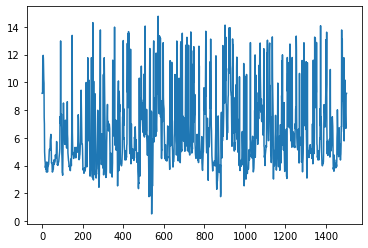

In [217]:
import pymap3d as pm
lat0 = gdf.geometry[0].coords[0][1]
lon0 = gdf.geometry[0].coords[0][0]
h0 = 0
lat = gdf.geometry[0].coords[1][1]
lon = gdf.geometry[0].coords[1][0]
h = 0
def get_local_coord(coord, coord0):
    lat0 = coord0[1]
    lon0 = coord0[0]
    lat = coord[1]
    lon = coord[0]
    return pm.geodetic2enu(lat, lon, 0, lat0, lon0, h0)[:2]
coords = gdf.geometry[0].coords
local_coords = [ get_local_coord(coord, coords[0]) for coord in coords]
local_coords

from scipy import optimize

x = [i[0] for i in local_coords[0:5]]
y = [i[1] for i in local_coords[0:5]]
x=[]
y=[]

# def calc_R(xc, yc, x, y):
#     """ calculate the distance of each 2D points from the center (xc, yc) """
#     return np.sqrt((x-xc)**2 + (y-yc)**2)

def f_2(c, x, y):
    """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
    Ri = np.sqrt((x-c[0])**2 + (y-c[1])**2)
    return Ri - Ri.mean()

def get_radius(i, local_coords, k):
    if i<k:
        return 10000
    if i+k>=len(local_coords):
        return 10000
    point_set = local_coords[i-k:i+k]
    x = [i[0] for i in point_set]
    y = [i[1] for i in point_set]
    
    center_estimate = (np.mean(x),np.mean(y))
    center, ier = optimize.leastsq(f_2, center_estimate, args=(x, y))
    #print(ier)
    Ri_2       = calc_R(*center, x, y)
    R_2        = Ri_2.mean()
    return R_2

get_radius(190, local_coords, 100)
radii = [get_radius(i, local_coords, 3) for i in range(len(local_coords))]
plt.plot(np.log(radii))

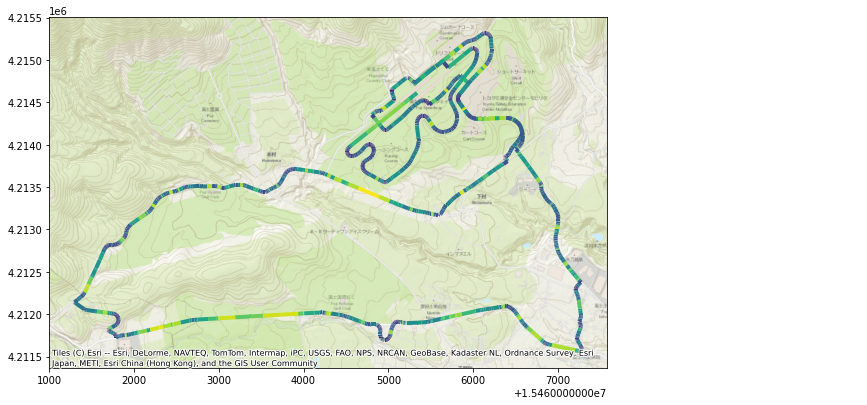

In [259]:
from shapely.geometry import Point
from shapely.geometry import LineString

import contextily as cx

def segments(curve):
    return list(map(LineString, zip(curve.coords[:-1], curve.coords[1:])))

line_segments = segments(gdf.geometry[0])
segment_radius = [(radii[i]+radii[i+1])/2 for i in range(len(radii)-1)]

tokyo_lines = gpd.GeoDataFrame(columns=['radius','geometry'],geometry='geometry')
tokyo_lines.geometry = line_segments
tokyo_lines.radius = np.log(segment_radius)

tokyo_lines.crs='epsg:4326'
tokyo_lines = tokyo_lines.to_crs(epsg=3857)
ax = tokyo_lines.plot(tokyo_lines.radius,linewidth=4,figsize=(10,10))
cx.add_basemap(ax, source=cx.providers.Esri.WorldTopoMap)

# Point(coords[0])
# tokyo = gpd.GeoDataFrame(columns=['radius', 'geometry'], 
#          geometry='geometry')
# points = [Point(coords[i]) for i in range(len(coords))]
# tokyo.geometry = points
# tokyo.radius = np.log(radii)
# tokyo.explore(tokyo.radius)

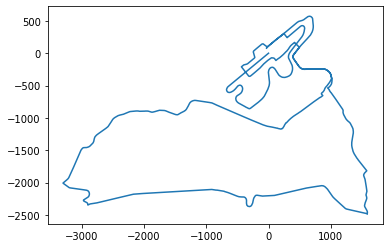

In [197]:
x = [i[0] for i in local_coords]
y = [i[1] for i in local_coords]
plt.plot(x,y)

In [65]:
# import sys
# sys.path.append('../elevation_profile')
# from ElevationSampler import DEM
# import pandas as pd
# from shapely.geometry import  LineString

# elevation_model = DEM("data/ASTGTMV003_N35E138_dem.tif")

# # define a line to sample along / or wrap in a geopandas GeoSeries for crs handling
# line = gdf.geometry[0]

# # sample every 10m along the line
# sample_distance = 10
# elevation_profile = elevation_model.elevation_profile(line, distance=sample_distance, interpolated=True)
# print(elevation_profile.inclination(degrees=True))

Loaded dem as EPSG:4326
[-1.53099179]


(138.9275082, 35.3724509)


1938

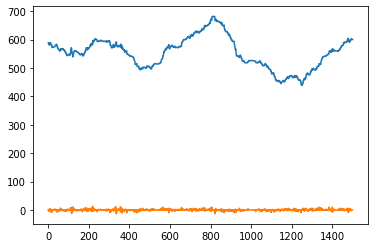

In [97]:
import srtm1
import matplotlib.pyplot as plt
def coord_to_alt(coord):
    lat = coord[1]
    lon = coord[0]
    return srtm1.read('data/ASTGTMV003_N35E138_dem.tif',lat, lon)



coord1 = gdf.geometry[0].coords[0]
print(coord1)
lat = coord1[1]
lon = coord1[0]
alts = [coord_to_alt(coord) for coord in gdf.geometry[0].coords]
alt_diffs = [alts[i+1]-alts[i] for i in range(len(alts)-1)]
#dists = 
plt.plot(alts)
plt.plot(alt_diffs)
sum([abs(diff) for diff in alt_diffs])


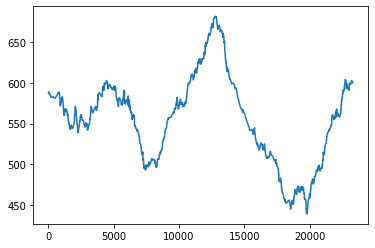

In [119]:
from haversine import haversine_vector, Unit
import numpy as np
coords_latlon = [x[::-1] for x in gdf.geometry[0].coords]
dists = haversine_vector(coords_latlon[1:],coords_latlon[:-1], Unit.METERS)
sum(dists)
cum_dists = np.insert(np.cumsum(dists),0,0)
plt.plot(cum_dists,alts)

In [67]:
type(line)

shapely.geometry.linestring.LineString

In [6]:

sys.path.append('../SRTM-GeoTIFF/library')

In [50]:
import tilename
tilename.find(gdf.geometry[0].coords[0][1],gdf.geometry[0].coords[0][0])

'N35E138.tif'

In [4]:
from requests import get
from pandas import json_normalize

def get_elevation(lat = None, long = None):
    '''
        script for returning elevation in m from lat, long
    '''
    if lat is None or long is None: return None
    
    query = ('https://api.open-elevation.com/api/v1/lookup'
             f'?locations={lat},{long}')
    
    # Request with a timeout for slow responses
    r = get(query, timeout = 20)

    # Only get the json response in case of 200 or 201
    if r.status_code == 200 or r.status_code == 201:
        elevation = json_normalize(r.json(), 'results')['elevation'].values[0]
    else: 
        elevation = None
    return elevation

In [5]:
get_elevation(0,0)

ReadTimeout: HTTPSConnectionPool(host='api.open-elevation.com', port=443): Read timed out. (read timeout=20)